# MRMS and GFS re-gridding

In [7]:
import sys
import time
import h5py
#import pygrib
import numpy as np
import netCDF4 as nc
from datetime import datetime, timedelta

In [2]:
# graph tools
import cmaps
import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/')
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/libs/')

from namelist import *
import data_utils as du

In [4]:
from scipy.spatial import cKDTree

## Spatial aggregation from 0.01 deg to 0.1 deg

In [5]:
def spatial_agregate(data, size=10):
    Nx, Ny = data.shape
    Nxa = Nx // 10; Nya = Ny // 10
    out = np.empty((Nxa, Nya))
    
    for i in range(Nxa):
        for j in range(Nya):
            out[i, j] = np.mean(data[i*size:(i*size+size), j*size:(j*size+size)])
    return out

In [6]:
with h5py.File(save_dir+'MRMS_domain.hdf', 'r') as h5io:
    lon_MRMS = h5io['lon_MRMS'][...]
    lat_MRMS = h5io['lat_MRMS'][...]
    elev_MRMS = h5io['elev_MRMS'][...]
    land_mask_MRMS = h5io['land_mask_MRMS'][...]

land_mask_01 = spatial_agregate(land_mask_MRMS, size=10)
land_mask_01[land_mask_01<0.5] = 0
land_mask_01[land_mask_01>=0.5] = 1

elev_01 = spatial_agregate(elev_MRMS, size=10)

lat_01 = spatial_agregate(lat_MRMS, size=10)
lon_01 = spatial_agregate(lon_MRMS, size=10)

land_mask_01 = land_mask_01[47:303, 53:629]
elev_01 = elev_01[47:303, 53:629]
lon_01 = lon_01[47:303, 53:629]
lat_01 = lat_01[47:303, 53:629]

elev_01[elev_01<0] = 0

## (Additional) Regrid elev to 0.25 deg 

In [10]:
with h5py.File(save_dir+'CNN_domain.hdf', 'r') as h5io:
    lon_GFS = h5io['lon_GFS'][...]
    lat_GFS = h5io['lat_GFS'][...]

In [8]:
from scipy.interpolate import griddata
import scipy.interpolate as spint
from scipy.spatial import Delaunay
import itertools

def interp_weights(xy, uv, d=2):
    tri = Delaunay(xy)
    simplex = tri.find_simplex(uv)
    vertices = np.take(tri.simplices, simplex, axis=0)
    temp = np.take(tri.transform, simplex, axis=0)
    delta = uv - temp[:, d]
    bary = np.einsum('njk,nk->nj', temp[:, :d, :], delta)
    return vertices, np.hstack((bary, 1 - bary.sum(axis=1, keepdims=True)))

def interpolate(values, vtx, wts):
    return np.einsum('nj,nj->n', np.take(values, vtx), wts)

In [9]:
with nc.Dataset('/glade/campaign/cisl/aiml/ksha/BACKUP/ETOPO1_Ice_g_gmt4.grd', 'r') as ncio:
    x = ncio['x'][2500:7400]
    y = ncio['y'][6500:9000]
    z = ncio['z'][6500:9000, 2500:7400]

long, lat = np.meshgrid(x, y)
long = np.array(long)
lat = np.array(lat)

In [11]:
# Computed once and for all
vtx, wts = interp_weights(np.vstack([long.ravel(), lat.ravel()]).T, 
                          np.vstack([lon_GFS.ravel(), lat_GFS.ravel()]).T)

In [12]:
start_time = time.time()
elev_GFS_temp = interpolate(z.ravel(), vtx, wts)
elev_GFS_temp = elev_GFS_temp.reshape(lon_GFS.shape)
print("--- %s seconds ---" % (time.time() - start_time))

elev_GFS = np.copy(elev_GFS_temp)

--- 0.0017857551574707031 seconds ---


In [14]:
elev_GFS[elev_GFS<0] = 0

In [16]:
# tuple_save = (lon_01, lat_01, elev_01, land_mask_01, lon_GFS, lat_GFS, elev_GFS)
# label_save = ['lon_01', 'lat_01', 'elev_01', 'land_mask_01', 'lon_GFS', 'lat_GFS', 'elev_GFS']
# du.save_hdf5(tuple_save, label_save, save_dir, 'CNN_domain.hdf')

Save to /glade/work/ksha/GAN/CNN_domain.hdf


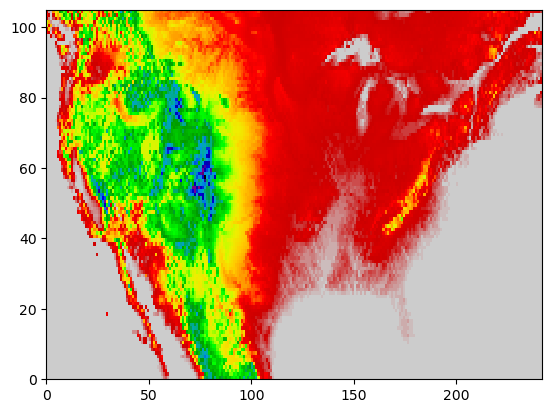

In [15]:
plt.pcolormesh(elev_GFS, cmap=plt.cm.nipy_spectral_r)

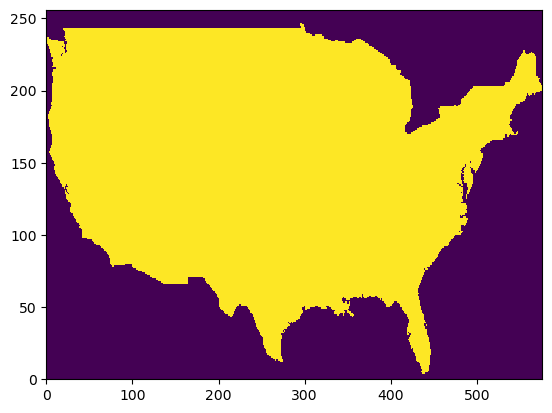

In [7]:
plt.pcolormesh(land_mask_01)

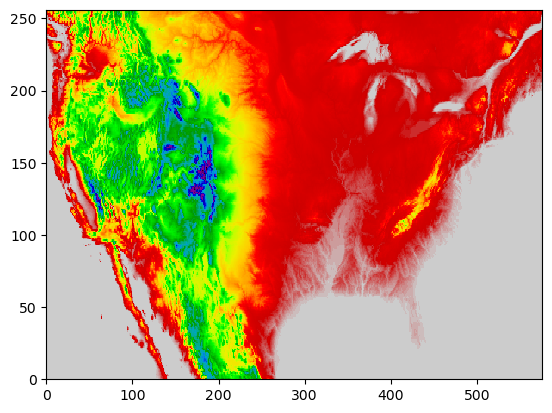

In [8]:
plt.pcolormesh(elev_01, cmap=plt.cm.nipy_spectral_r)

## Save data

In [9]:
# tuple_save = (lon_01, lat_01, elev_01, land_mask_01)
# label_save = ['lon_01', 'lat_01', 'elev_01', 'land_mask_01']
# du.save_hdf5(tuple_save, label_save, save_dir, 'CNN_domain.hdf')

Save to /glade/work/ksha/GAN/CNN_domain.hdf
